In [1]:
# 🚀 Forex Currency Prediction Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
import joblib
import warnings
import os
from datetime import datetime, timedelta
import time
warnings.filterwarnings('ignore')

print("🎉 Full-Scale Forex Prediction System Initialized!")
print(f"📊 TensorFlow: {tf.__version__}")
print(f"🔮 Prophet: Available")
print(f"📈 XGBoost: Available")
print(f"📊 Training Configuration: ALL CURRENCIES, EXTENDED PERIOD")

🎉 Full-Scale Forex Prediction System Initialized!
📊 TensorFlow: 2.19.0
🔮 Prophet: Available
📈 XGBoost: Available
📊 Training Configuration: ALL CURRENCIES, EXTENDED PERIOD


In [3]:
#Enhanced Configuration for full-scale training
class FullScaleConfig:
    """Configuration for full-scale training"""
    
    # Data parameters
    LOOKBACK_DAYS = 120  # Extended lookback for more features
    TEST_SIZE = 0.15     # Smaller test size to maximize training data
    
    # Model parameters
    TRAIN_ALL_CURRENCIES = True
    MAX_CURRENCIES = None  # No limit - train on all available
    
    # LSTM parameters (enhanced for longer sequences)
    LSTM_LOOKBACK = 90   # 3 months of data for LSTM
    LSTM_EPOCHS = 150    # More epochs for complex patterns
    LSTM_BATCH_SIZE = 64 # Larger batch size for stability
    
    # Feature engineering
    ROLLING_WINDOWS = [5, 10, 20, 30, 60, 90, 120]  # Extended windows
    TECHNICAL_INDICATORS = True
    ADVANCED_FEATURES = True
    
    # Performance optimization
    USE_MULTIPROCESSING = True
    EARLY_STOPPING_PATIENCE = 20
    
    # Output settings
    SAVE_ALL_MODELS = True
    CREATE_DETAILED_REPORTS = True
    GENERATE_FORECASTS = True

config = FullScaleConfig()

In [4]:
#Data Loading
def load_complete_forex_data():
    """Load the complete forex dataset with minimal processing"""
    print("📊 Loading complete forex dataset...")
    
    data_files = [
        "Foreign_Exchange_Rates.xls",
        "data/Foreign_Exchange_Rates.xls",
        "../Foreign_Exchange_Rates.xls"
    ]
    
    for file_path in data_files:
        try:
            print(f"📂 Attempting to load: {file_path}")
            
            # Try different file formats
            if file_path.endswith('.xls') or file_path.endswith('.xlsx'):
                try:
                    data = pd.read_excel(file_path)
                except:
                    data = pd.read_csv(file_path)  # Sometimes .xls files are actually CSV
            else:
                data = pd.read_csv(file_path)
            
            # Clean up columns
            data = data.drop([col for col in data.columns if 'Unnamed' in str(col) or col.startswith('_')], axis=1)
            
            # Find and process date column
            date_col = None
            for col in data.columns:
                if any(word in col.lower() for word in ['time', 'date', 'serie']):
                    date_col = col
                    break
            
            if date_col:
                # Try multiple date formats
                for fmt in ['%d-%m-%Y', '%Y-%m-%d', '%m/%d/%Y']:
                    try:
                        data[date_col] = pd.to_datetime(data[date_col], format=fmt)
                        break
                    except:
                        continue
                
                # If no format worked, try auto-parsing
                if data[date_col].dtype == 'object':
                    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
                
                data = data.rename(columns={date_col: 'Date'})
                data.set_index('Date', inplace=True)
                data = data.sort_index()
            
            # Convert all columns to numeric
            for col in data.columns:
                data[col] = pd.to_numeric(data[col], errors='coerce')
            
            # Remove any rows with all NaN values
            data = data.dropna(how='all')
            
            print(f"✅ Successfully loaded complete dataset!")
            print(f"📊 Shape: {data.shape}")
            print(f"📅 Date range: {data.index.min()} to {data.index.max()}")
            print(f"💱 Total currencies: {len(data.columns)}")
            print(f"📈 Total data points: {data.count().sum():,}")
            
            return data
            
        except Exception as e:
            print(f"❌ Failed to load {file_path}: {str(e)}")
            continue
    
    print("❌ Could not load data from any location")
    return create_comprehensive_sample_data()

def create_comprehensive_sample_data():
    """Create comprehensive sample data if real data unavailable"""
    print("💡 Creating comprehensive sample dataset...")
    
    np.random.seed(42)
    # Extended date range - 25 years of data
    dates = pd.date_range('2000-01-01', '2024-12-31', freq='D')
    
    # All major currency pairs with realistic parameters
    currencies = {
        'EURO AREA - EURO/US$': {'start': 1.18, 'volatility': 0.008, 'trend': 0.0001},
        'UNITED KINGDOM - UNITED KINGDOM POUND/US$': {'start': 1.28, 'volatility': 0.012, 'trend': -0.0001},
        'JAPAN - YEN/US$': {'start': 110.0, 'volatility': 0.8, 'trend': 0.02},
        'CANADA - CANADIAN DOLLAR/US$': {'start': 1.33, 'volatility': 0.006, 'trend': 0.00005},
        'AUSTRALIA - AUSTRALIAN DOLLAR/US$': {'start': 0.72, 'volatility': 0.010, 'trend': -0.00003},
        'SWITZERLAND - FRANC/US$': {'start': 0.92, 'volatility': 0.007, 'trend': -0.00002},
        'CHINA - YUAN/US$': {'start': 6.45, 'volatility': 0.015, 'trend': 0.0003},
        'INDIA - INDIAN RUPEE/US$': {'start': 74.0, 'volatility': 0.3, 'trend': 0.01},
        'BRAZIL - REAL/US$': {'start': 5.2, 'volatility': 0.05, 'trend': 0.001},
        'SOUTH AFRICA - RAND/US$': {'start': 14.5, 'volatility': 0.15, 'trend': 0.002},
        'MEXICO - MEXICAN PESO/US$': {'start': 9.5, 'volatility': 0.08, 'trend': 0.0008},
        'KOREA - WON/US$': {'start': 1200, 'volatility': 8, 'trend': 0.05},
        'SINGAPORE - SINGAPORE DOLLAR/US$': {'start': 1.35, 'volatility': 0.005, 'trend': 0.00001},
        'HONG KONG - HONG KONG DOLLAR/US$': {'start': 7.75, 'volatility': 0.002, 'trend': 0.0001},
        'NORWAY - NORWEGIAN KRONE/US$': {'start': 8.5, 'volatility': 0.012, 'trend': 0.0002},
        'SWEDEN - KRONA/US$': {'start': 9.2, 'volatility': 0.011, 'trend': 0.0001},
        'DENMARK - DANISH KRONE/US$': {'start': 6.8, 'volatility': 0.008, 'trend': 0.00005},
        'THAILAND - BAHT/US$': {'start': 36.0, 'volatility': 0.4, 'trend': 0.005},
        'MALAYSIA - RINGGIT/US$': {'start': 4.2, 'volatility': 0.03, 'trend': 0.0003},
        'TAIWAN - NEW TAIWAN DOLLAR/US$': {'start': 31.0, 'volatility': 0.25, 'trend': 0.002},
        'SRI LANKA - SRI LANKAN RUPEE/US$': {'start': 190, 'volatility': 2.5, 'trend': 0.05}
    }
    
    data = pd.DataFrame(index=dates)
    
    for currency, params in currencies.items():
        n_days = len(dates)
        
        # Create realistic time series with multiple components
        
        # 1. Trend component
        trend = np.linspace(0, params['trend'] * n_days, n_days)
        
        # 2. Seasonal components
        annual_seasonal = 0.02 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)
        monthly_seasonal = 0.01 * np.sin(2 * np.pi * np.arange(n_days) / 30.44)
        
        # 3. Economic cycle (7-year cycle)
        economic_cycle = 0.03 * np.sin(2 * np.pi * np.arange(n_days) / (365.25 * 7))
        
        # 4. Random walk with volatility clustering
        returns = np.random.normal(0, params['volatility'], n_days)
        
        # Add volatility clustering (GARCH-like effect)
        volatility = np.ones(n_days) * params['volatility']
        for i in range(1, n_days):
            volatility[i] = 0.95 * volatility[i-1] + 0.05 * abs(returns[i-1])
            returns[i] = np.random.normal(0, volatility[i])
        
        # 5. Occasional jumps (crisis events)
        jump_probability = 0.001  # 0.1% chance per day
        jumps = np.random.binomial(1, jump_probability, n_days)
        jump_sizes = np.random.normal(0, params['volatility'] * 5, n_days) * jumps
        
        # Combine all components
        log_prices = (trend + annual_seasonal + monthly_seasonal + 
                     economic_cycle + np.cumsum(returns) + np.cumsum(jump_sizes))
        
        prices = params['start'] * np.exp(log_prices)
        data[currency] = prices
    
    print(f"✅ Comprehensive sample data created!")
    print(f"📊 Shape: {data.shape}")
    print(f"💱 Currencies: {len(data.columns)}")
    
    return data

# Load the complete dataset
forex_data = load_complete_forex_data()

📊 Loading complete forex dataset...
📂 Attempting to load: Foreign_Exchange_Rates.xls
✅ Successfully loaded complete dataset!
📊 Shape: (5020, 22)
📅 Date range: 2000-01-03 00:00:00 to 2019-12-31 00:00:00
💱 Total currencies: 22
📈 Total data points: 110,415


In [5]:
#Feature Engineering
def create_comprehensive_features(data, target_col, lookback_days=120):
    """Create comprehensive feature set with extended lookback"""
    print(f"🔧 Creating comprehensive features for {target_col}...")
    print(f"   📊 Lookback period: {lookback_days} days")
    
    df = data[[target_col]].copy()
    original_length = len(df)
    
    # 1. Extended lag features
    lag_periods = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90]
    for lag in lag_periods:
        if lag <= lookback_days:
            df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # 2. Comprehensive rolling statistics
    for window in config.ROLLING_WINDOWS:
        if len(df) > window:
            df[f'rolling_mean_{window}'] = df[target_col].rolling(window).mean()
            df[f'rolling_std_{window}'] = df[target_col].rolling(window).std()
            df[f'rolling_max_{window}'] = df[target_col].rolling(window).max()
            df[f'rolling_min_{window}'] = df[target_col].rolling(window).min()
            df[f'rolling_median_{window}'] = df[target_col].rolling(window).median()
            df[f'rolling_skew_{window}'] = df[target_col].rolling(window).skew()
            df[f'rolling_kurt_{window}'] = df[target_col].rolling(window).kurt()
    
    # 3. Advanced technical indicators
    if config.TECHNICAL_INDICATORS and len(df) > 50:
        # Moving averages
        ma_periods = [5, 10, 20, 50, 100, 200]
        for period in ma_periods:
            if len(df) > period:
                df[f'sma_{period}'] = df[target_col].rolling(period).mean()
                df[f'ema_{period}'] = df[target_col].ewm(span=period).mean()
        
        # MACD with multiple settings
        if len(df) > 26:
            for fast, slow, signal in [(12, 26, 9), (8, 21, 5), (19, 39, 9)]:
                ema_fast = df[target_col].ewm(span=fast).mean()
                ema_slow = df[target_col].ewm(span=slow).mean()
                macd = ema_fast - ema_slow
                macd_signal = macd.ewm(span=signal).mean()
                
                df[f'macd_{fast}_{slow}'] = macd
                df[f'macd_signal_{fast}_{slow}_{signal}'] = macd_signal
                df[f'macd_histogram_{fast}_{slow}_{signal}'] = macd - macd_signal
        
        # RSI with multiple periods
        for rsi_period in [14, 21, 30]:
            if len(df) > rsi_period:
                delta = df[target_col].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
                rs = gain / loss
                df[f'rsi_{rsi_period}'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands with multiple settings
        for bb_period, bb_std in [(20, 2), (10, 1.5), (50, 2.5)]:
            if len(df) > bb_period:
                bb_middle = df[target_col].rolling(bb_period).mean()
                bb_std_dev = df[target_col].rolling(bb_period).std()
                bb_upper = bb_middle + (bb_std_dev * bb_std)
                bb_lower = bb_middle - (bb_std_dev * bb_std)
                
                df[f'bb_middle_{bb_period}'] = bb_middle
                df[f'bb_upper_{bb_period}_{bb_std}'] = bb_upper
                df[f'bb_lower_{bb_period}_{bb_std}'] = bb_lower
                df[f'bb_width_{bb_period}_{bb_std}'] = bb_upper - bb_lower
                df[f'bb_position_{bb_period}_{bb_std}'] = (df[target_col] - bb_lower) / (bb_upper - bb_lower)
        
        # Stochastic Oscillator
        if len(df) > 14:
            for k_period, d_period in [(14, 3), (21, 5)]:
                if len(df) > k_period:
                    lowest_low = df[target_col].rolling(k_period).min()
                    highest_high = df[target_col].rolling(k_period).max()
                    k_percent = 100 * ((df[target_col] - lowest_low) / (highest_high - lowest_low))
                    d_percent = k_percent.rolling(d_period).mean()
                    
                    df[f'stoch_k_{k_period}'] = k_percent
                    df[f'stoch_d_{k_period}_{d_period}'] = d_percent
        
        # Williams %R
        if len(df) > 14:
            for wr_period in [14, 21]:
                if len(df) > wr_period:
                    highest_high = df[target_col].rolling(wr_period).max()
                    lowest_low = df[target_col].rolling(wr_period).min()
                    df[f'williams_r_{wr_period}'] = -100 * ((highest_high - df[target_col]) / (highest_high - lowest_low))
    
    # 4. Price-based features with multiple timeframes
    price_change_periods = [1, 2, 3, 5, 7, 14, 21, 30, 60, 90]
    for period in price_change_periods:
        if period <= lookback_days:
            df[f'price_change_{period}d'] = df[target_col].pct_change(period)
            df[f'price_diff_{period}d'] = df[target_col].diff(period)
    
    # 5. Volatility features
    for vol_window in [5, 10, 20, 30, 60]:
        if len(df) > vol_window:
            returns = df[target_col].pct_change()
            df[f'volatility_{vol_window}d'] = returns.rolling(vol_window).std() * np.sqrt(252)
            df[f'realized_vol_{vol_window}d'] = returns.rolling(vol_window).apply(lambda x: np.sqrt(np.sum(x**2)))
    
    # 6. Advanced statistical features
    if config.ADVANCED_FEATURES:
        for window in [20, 60, 120]:
            if len(df) > window:
                returns = df[target_col].pct_change()
                
                # Higher moments
                df[f'skewness_{window}d'] = returns.rolling(window).skew()
                df[f'kurtosis_{window}d'] = returns.rolling(window).kurt()
                
                # Autocorrelation
                df[f'autocorr_1_{window}d'] = returns.rolling(window).apply(lambda x: x.autocorr(lag=1))
                df[f'autocorr_5_{window}d'] = returns.rolling(window).apply(lambda x: x.autocorr(lag=5))
                
                # Trend strength
                df[f'trend_strength_{window}d'] = df[target_col].rolling(window).apply(
                    lambda x: np.corrcoef(np.arange(len(x)), x)[0, 1] if len(x) > 1 else 0
                )
    
    # 7. Cross-currency features (if other currencies available)
    other_currencies = [col for col in data.columns if col != target_col][:3]  # Top 3 others
    for other_curr in other_currencies:
        if other_curr in data.columns:
            # Currency correlations
            for window in [30, 60, 120]:
                if len(df) > window:
                    df[f'corr_{other_curr.split()[0]}_{window}d'] = df[target_col].rolling(window).corr(data[other_curr])
            
            # Relative strength
            df[f'relative_strength_{other_curr.split()[0]}'] = df[target_col] / data[other_curr]
    
    # 8. Enhanced date and time features
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)
    
    # 9. Cyclical encoding for better ML performance
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    # 10. Economic calendar features (simplified)
    # Add day-of-week and month patterns that might reflect economic announcements
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)  # NFP day
    df['is_first_week'] = (df.index.day <= 7).astype(int)   # Common for central bank meetings
    
    # Remove rows with NaN values
    df_clean = df.dropna()
    
    print(f"✅ Comprehensive feature engineering completed!")
    print(f"   📊 Original length: {original_length:,}")
    print(f"   📊 After cleaning: {len(df_clean):,}")
    print(f"   🔧 Total features: {len(df_clean.columns) - 1}")
    print(f"   📉 Data reduction: {((original_length - len(df_clean)) / original_length * 100):.1f}%")
    
    return df_clean

In [6]:
# Test feature engineering on one currency first
test_currency = forex_data.columns[0]  # First currency in your dataset
print(f"🧪 Testing feature engineering on: {test_currency}")

# Run feature engineering for this currency
test_features = create_comprehensive_features(forex_data, test_currency, lookback_days=120)

print(f"\n📊 Feature Engineering Results:")
print(f"   Original data: {len(forex_data)} rows")
print(f"   After features: {len(test_features)} rows")
print(f"   Total features: {len(test_features.columns) - 1}")
print(f"   Feature list (first 10):")
for i, col in enumerate(list(test_features.columns)[:10], 1):
    if col != test_currency:
        print(f"     {i}. {col}")

🧪 Testing feature engineering on: AUSTRALIA - AUSTRALIAN DOLLAR/US$
🔧 Creating comprehensive features for AUSTRALIA - AUSTRALIAN DOLLAR/US$...
   📊 Lookback period: 120 days
✅ Comprehensive feature engineering completed!
   📊 Original length: 5,020
   📊 After cleaning: 4,621
   🔧 Total features: 183
   📉 Data reduction: 7.9%

📊 Feature Engineering Results:
   Original data: 5020 rows
   After features: 4621 rows
   Total features: 183
   Feature list (first 10):
     2. lag_1
     3. lag_2
     4. lag_3
     5. lag_5
     6. lag_7
     7. lag_10
     8. lag_14
     9. lag_21
     10. lag_30


In [7]:
#TRAINING
import time
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import joblib
import warnings
warnings.filterwarnings('ignore')

def clean_data_ultra_safe(series):
    """Ultra-safe data cleaning that handles all data type issues"""
    try:
        # Convert to numeric, coercing errors to NaN
        series = pd.to_numeric(series, errors='coerce')
        
        # Replace infinite values with NaN
        series = series.replace([np.inf, -np.inf], np.nan)
        
        # Remove any remaining problematic values
        series = series.dropna()
        
        return series
    except:
        return pd.Series(dtype=float)

def create_ultra_safe_features(data, target_col):
    """Ultra-safe feature engineering with bulletproof data handling"""
    print(f"🔧 Creating ultra-safe features for {target_col}...")
    
    try:
        # Extract and clean target column
        target_series = data[target_col].copy()
        target_series = clean_data_ultra_safe(target_series)
        
        if len(target_series) < 200:
            print(f"   ⚠️ Insufficient clean data: {len(target_series)} rows")
            return None
        
        # Create DataFrame with cleaned target
        df = pd.DataFrame({'target': target_series})
        df.index = target_series.index
        
        # 1. Basic lag features (ultra-safe)
        print("   📊 Adding lag features...")
        for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
            if lag < len(df) // 4:
                lag_series = target_series.shift(lag)
                lag_series = clean_data_ultra_safe(lag_series)
                df[f'lag_{lag}'] = lag_series
        
        # 2. Rolling statistics (ultra-safe)
        print("   📈 Adding rolling statistics...")
        for window in [5, 10, 20, 30]:
            if window < len(df) // 3:
                try:
                    # Rolling mean
                    rolling_mean = target_series.rolling(window=window, min_periods=max(1, window//2)).mean()
                    rolling_mean = clean_data_ultra_safe(rolling_mean)
                    df[f'rolling_mean_{window}'] = rolling_mean
                    
                    # Rolling std
                    rolling_std = target_series.rolling(window=window, min_periods=max(1, window//2)).std()
                    rolling_std = clean_data_ultra_safe(rolling_std)
                    df[f'rolling_std_{window}'] = rolling_std
                    
                except:
                    continue
        
        # 3. Simple price changes (ultra-safe)
        print("   💹 Adding price changes...")
        for period in [1, 7, 14, 30]:
            if period < len(df) // 4:
                try:
                    pct_change = target_series.pct_change(period)
                    pct_change = clean_data_ultra_safe(pct_change)
                    df[f'price_change_{period}d'] = pct_change
                except:
                    continue
        
        # 4. Simple technical indicators (ultra-safe)
        print("   🔧 Adding technical indicators...")
        try:
            if len(df) > 20:
                sma_5 = target_series.rolling(5, min_periods=3).mean()
                sma_5 = clean_data_ultra_safe(sma_5)
                df['sma_5'] = sma_5
                
                sma_20 = target_series.rolling(20, min_periods=10).mean()
                sma_20 = clean_data_ultra_safe(sma_20)
                df['sma_20'] = sma_20
        except:
            pass
        
        # 5. Simple date features (ultra-safe)
        print("   📅 Adding date features...")
        try:
            df['day_of_week'] = df.index.dayofweek
            df['month'] = df.index.month
            df['quarter'] = df.index.quarter
            
            # Simple cyclical encoding
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        except:
            pass
        
        # 6. Ultra-safe final cleaning
        print("   🧹 Final data cleaning...")
        
        # Convert all columns to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Remove infinite and NaN values
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        
        # Rename target column back
        df = df.rename(columns={'target': target_col})
        
        # Final validation
        if len(df) < 100:
            print(f"   ⚠️ Not enough clean data after processing: {len(df)} rows")
            return None
        
        # Check for any remaining data issues
        if df.isnull().sum().sum() > 0:
            print(f"   ⚠️ Still contains NaN values")
            return None
        
        print(f"   ✅ Success! Features: {len(df.columns)-1}, Samples: {len(df)}")
        return df
        
    except Exception as e:
        print(f"   ❌ Feature creation failed: {str(e)}")
        return None

def train_ultra_safe_models(forex_data):
    """Ultra-safe model training for all currencies"""
    
    all_currencies = forex_data.columns.tolist()
    print(f"🛡️ ULTRA-SAFE TRAINING FOR ALL {len(all_currencies)} CURRENCIES")
    print("=" * 100)
    
    training_summary = {}
    failed_currencies = []
    start_time = time.time()
    
    for i, currency in enumerate(all_currencies, 1):
        currency_name = currency.split(' - ')[0] if ' - ' in currency else currency
        
        print(f"\n🚀 [{i:2d}/{len(all_currencies)}] {currency_name}")
        print("-" * 60)
        
        try:
            # Step 1: Ultra-safe feature engineering
            currency_df = create_ultra_safe_features(forex_data, currency)
            
            if currency_df is None:
                failed_currencies.append((currency, "Feature engineering failed"))
                continue
            
            # Step 2: Ultra-safe data preparation
            print("   📊 Preparing data...")
            
            # Separate features and target with extra safety
            try:
                X = currency_df.drop(columns=[currency])
                y = currency_df[currency]
                
                # Convert to numpy arrays and ensure proper types
                X_values = X.values.astype(np.float64)
                y_values = y.values.astype(np.float64)
                
                # Check for any remaining issues
                if np.any(np.isnan(X_values)) or np.any(np.isnan(y_values)):
                    print("   ❌ NaN values in final data")
                    failed_currencies.append((currency, "NaN in final data"))
                    continue
                
                if np.any(np.isinf(X_values)) or np.any(np.isinf(y_values)):
                    print("   ❌ Infinite values in final data")
                    failed_currencies.append((currency, "Infinite in final data"))
                    continue
                
                # Recreate DataFrames with clean data
                X = pd.DataFrame(X_values, columns=X.columns, index=X.index)
                y = pd.Series(y_values, index=y.index)
                
            except Exception as e:
                print(f"   ❌ Data preparation error: {str(e)}")
                failed_currencies.append((currency, "Data prep error"))
                continue
            
            # Dimension check
            if len(X) != len(y):
                print(f"   ❌ Dimension mismatch: X={len(X)}, y={len(y)}")
                failed_currencies.append((currency, "Dimension mismatch"))
                continue
            
            if len(X) < 100:
                print(f"   ❌ Insufficient samples: {len(X)}")
                failed_currencies.append((currency, "Insufficient samples"))
                continue
            
            # Step 3: Train/test split
            split_idx = int(len(X) * 0.8)
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
            
            print(f"   📈 Train: {len(X_train)}, Test: {len(X_test)}, Features: {len(X.columns)}")
            
            # Step 4: Train models with ultra-safe error handling
            models = {}
            results = {}
            
            # Model 1: Linear Regression
            try:
                print("   🤖 Training Linear Regression...")
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train.values)
                X_test_scaled = scaler.transform(X_test.values)
                
                lr_model = LinearRegression()
                lr_model.fit(X_train_scaled, y_train.values)
                lr_pred = lr_model.predict(X_test_scaled)
                
                # Ensure predictions are clean
                lr_pred = np.array(lr_pred, dtype=np.float64)
                y_test_clean = np.array(y_test.values, dtype=np.float64)
                
                lr_mae = mean_absolute_error(y_test_clean, lr_pred)
                lr_mape = mean_absolute_percentage_error(y_test_clean, lr_pred) * 100
                
                models['Linear_Regression'] = lr_model
                results['Linear_Regression'] = {
                    'MAE': lr_mae, 'MAPE': lr_mape, 'scaler': scaler
                }
                print(f"      ✅ LR - MAPE: {lr_mape:.2f}%")
                
            except Exception as e:
                print(f"      ❌ Linear Regression failed: {str(e)}")
            
            # Model 2: Random Forest
            try:
                print("   🌳 Training Random Forest...")
                rf_model = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=10,
                    random_state=42,
                    n_jobs=1
                )
                rf_model.fit(X_train.values, y_train.values)
                rf_pred = rf_model.predict(X_test.values)
                
                # Ensure predictions are clean
                rf_pred = np.array(rf_pred, dtype=np.float64)
                y_test_clean = np.array(y_test.values, dtype=np.float64)
                
                rf_mae = mean_absolute_error(y_test_clean, rf_pred)
                rf_mape = mean_absolute_percentage_error(y_test_clean, rf_pred) * 100
                
                models['Random_Forest'] = rf_model
                results['Random_Forest'] = {
                    'MAE': rf_mae, 'MAPE': rf_mape
                }
                print(f"      ✅ RF - MAPE: {rf_mape:.2f}%")
                
            except Exception as e:
                print(f"      ❌ Random Forest failed: {str(e)}")
            
            # Model 3: XGBoost (if no errors so far)
            if len(results) > 0:
                try:
                    print("   🚀 Training XGBoost...")
                    xgb_model = xgb.XGBRegressor(
                        n_estimators=100,
                        max_depth=6,
                        learning_rate=0.1,
                        random_state=42,
                        verbosity=0
                    )
                    xgb_model.fit(X_train.values, y_train.values)
                    xgb_pred = xgb_model.predict(X_test.values)
                    
                    # Ensure predictions are clean
                    xgb_pred = np.array(xgb_pred, dtype=np.float64)
                    y_test_clean = np.array(y_test.values, dtype=np.float64)
                    
                    xgb_mae = mean_absolute_error(y_test_clean, xgb_pred)
                    xgb_mape = mean_absolute_percentage_error(y_test_clean, xgb_pred) * 100
                    
                    models['XGBoost'] = xgb_model
                    results['XGBoost'] = {
                        'MAE': xgb_mae, 'MAPE': xgb_mape
                    }
                    print(f"      ✅ XGB - MAPE: {xgb_mape:.2f}%")
                    
                except Exception as e:
                    print(f"      ❌ XGBoost failed: {str(e)}")
            
            # Step 5: Select best model and save
            if not results:
                print("   ❌ No models succeeded")
                failed_currencies.append((currency, "All models failed"))
                continue
            
            # Find best model
            best_model_name = min(results.keys(), key=lambda k: results[k]['MAPE'])
            best_performance = results[best_model_name]
            
            print(f"   🏆 Best: {best_model_name} (MAPE: {best_performance['MAPE']:.2f}%)")
            
            # Save model
            os.makedirs('models', exist_ok=True)
            safe_name = currency_name.replace(' ', '_').replace('/', '_').replace('-', '_')
            model_filename = f"models/{safe_name}_model.pkl"
            
            model_data = {
                'model': models[best_model_name],
                'model_type': best_model_name,
                'target_col': currency,
                'currency_name': currency_name,
                'performance': best_performance,
                'scaler': best_performance.get('scaler'),
                'feature_columns': X.columns.tolist(),
                'training_date': pd.Timestamp.now()
            }
            
            joblib.dump(model_data, model_filename)
            
            training_summary[currency] = {
                'currency_name': currency_name,
                'champion_model': best_model_name,
                'performance': best_performance,
                'model_file': model_filename
            }
            
            print(f"   ✅ Saved: {model_filename}")
            
        except Exception as e:
            print(f"   ❌ Unexpected error: {str(e)}")
            failed_currencies.append((currency, f"Unexpected: {str(e)[:30]}"))
    
    total_time = time.time() - start_time
    return training_summary, failed_currencies, total_time

# 🚀 RUN ULTRA-SAFE TRAINING
print("🛡️ Starting Ultra-Safe Training...")
training_summary, failed_currencies, total_time = train_ultra_safe_models(forex_data)

# 📊 RESULTS
print(f"\n{'='*80}")
print("🏁 ULTRA-SAFE TRAINING RESULTS")
print(f"{'='*80}")

successful = len(training_summary)
total = successful + len(failed_currencies)

print(f"\n📊 SUMMARY:")
print(f"   ✅ Successful: {successful}/{total}")
print(f"   📈 Success rate: {successful/total*100:.1f}%")
print(f"   ⏱️ Time: {total_time/60:.1f} minutes")

if training_summary:
    print(f"\n🏆 TRAINED MODELS:")
    for currency, info in training_summary.items():
        name = info['currency_name']
        model = info['champion_model']
        mape = info['performance']['MAPE']
        print(f"   💱 {name:20} | {model:15} | MAPE: {mape:5.2f}%")

if failed_currencies:
    print(f"\n❌ FAILED ({len(failed_currencies)}):")
    for currency, reason in failed_currencies:
        name = currency.split(' - ')[0] if ' - ' in currency else currency
        print(f"   • {name:20}: {reason}")

print(f"\n🚀 Ready for deployment!")
print(f"   📱 streamlit run app.py")
print(f"   🐳 docker-compose up --build")

🛡️ Starting Ultra-Safe Training...
🛡️ ULTRA-SAFE TRAINING FOR ALL 22 CURRENCIES

🚀 [ 1/22] AUSTRALIA
------------------------------------------------------------
🔧 Creating ultra-safe features for AUSTRALIA - AUSTRALIAN DOLLAR/US$...
   📊 Adding lag features...
   📈 Adding rolling statistics...
   💹 Adding price changes...
   🔧 Adding technical indicators...
   📅 Adding date features...
   🧹 Final data cleaning...
   ✅ Success! Features: 27, Samples: 4989
   📊 Preparing data...
   📈 Train: 3991, Test: 998, Features: 27
   🤖 Training Linear Regression...
      ✅ LR - MAPE: 0.03%
   🌳 Training Random Forest...
      ✅ RF - MAPE: 0.15%
   🚀 Training XGBoost...
      ✅ XGB - MAPE: 0.15%
   🏆 Best: Linear_Regression (MAPE: 0.03%)
   ✅ Saved: models/AUSTRALIA_model.pkl

🚀 [ 2/22] EURO AREA
------------------------------------------------------------
🔧 Creating ultra-safe features for EURO AREA - EURO/US$...
   📊 Adding lag features...
   📈 Adding rolling statistics...
   💹 Adding price chang

🚀 STARTING FIXED COMPREHENSIVE PERFORMANCE ANALYSIS
📂 Loading all trained models...
✅ Loaded 22 trained models
✅ Found 22 trained models to analyze

📊 Creating Performance Dashboard...
📊 Creating performance dashboard with Matplotlib...


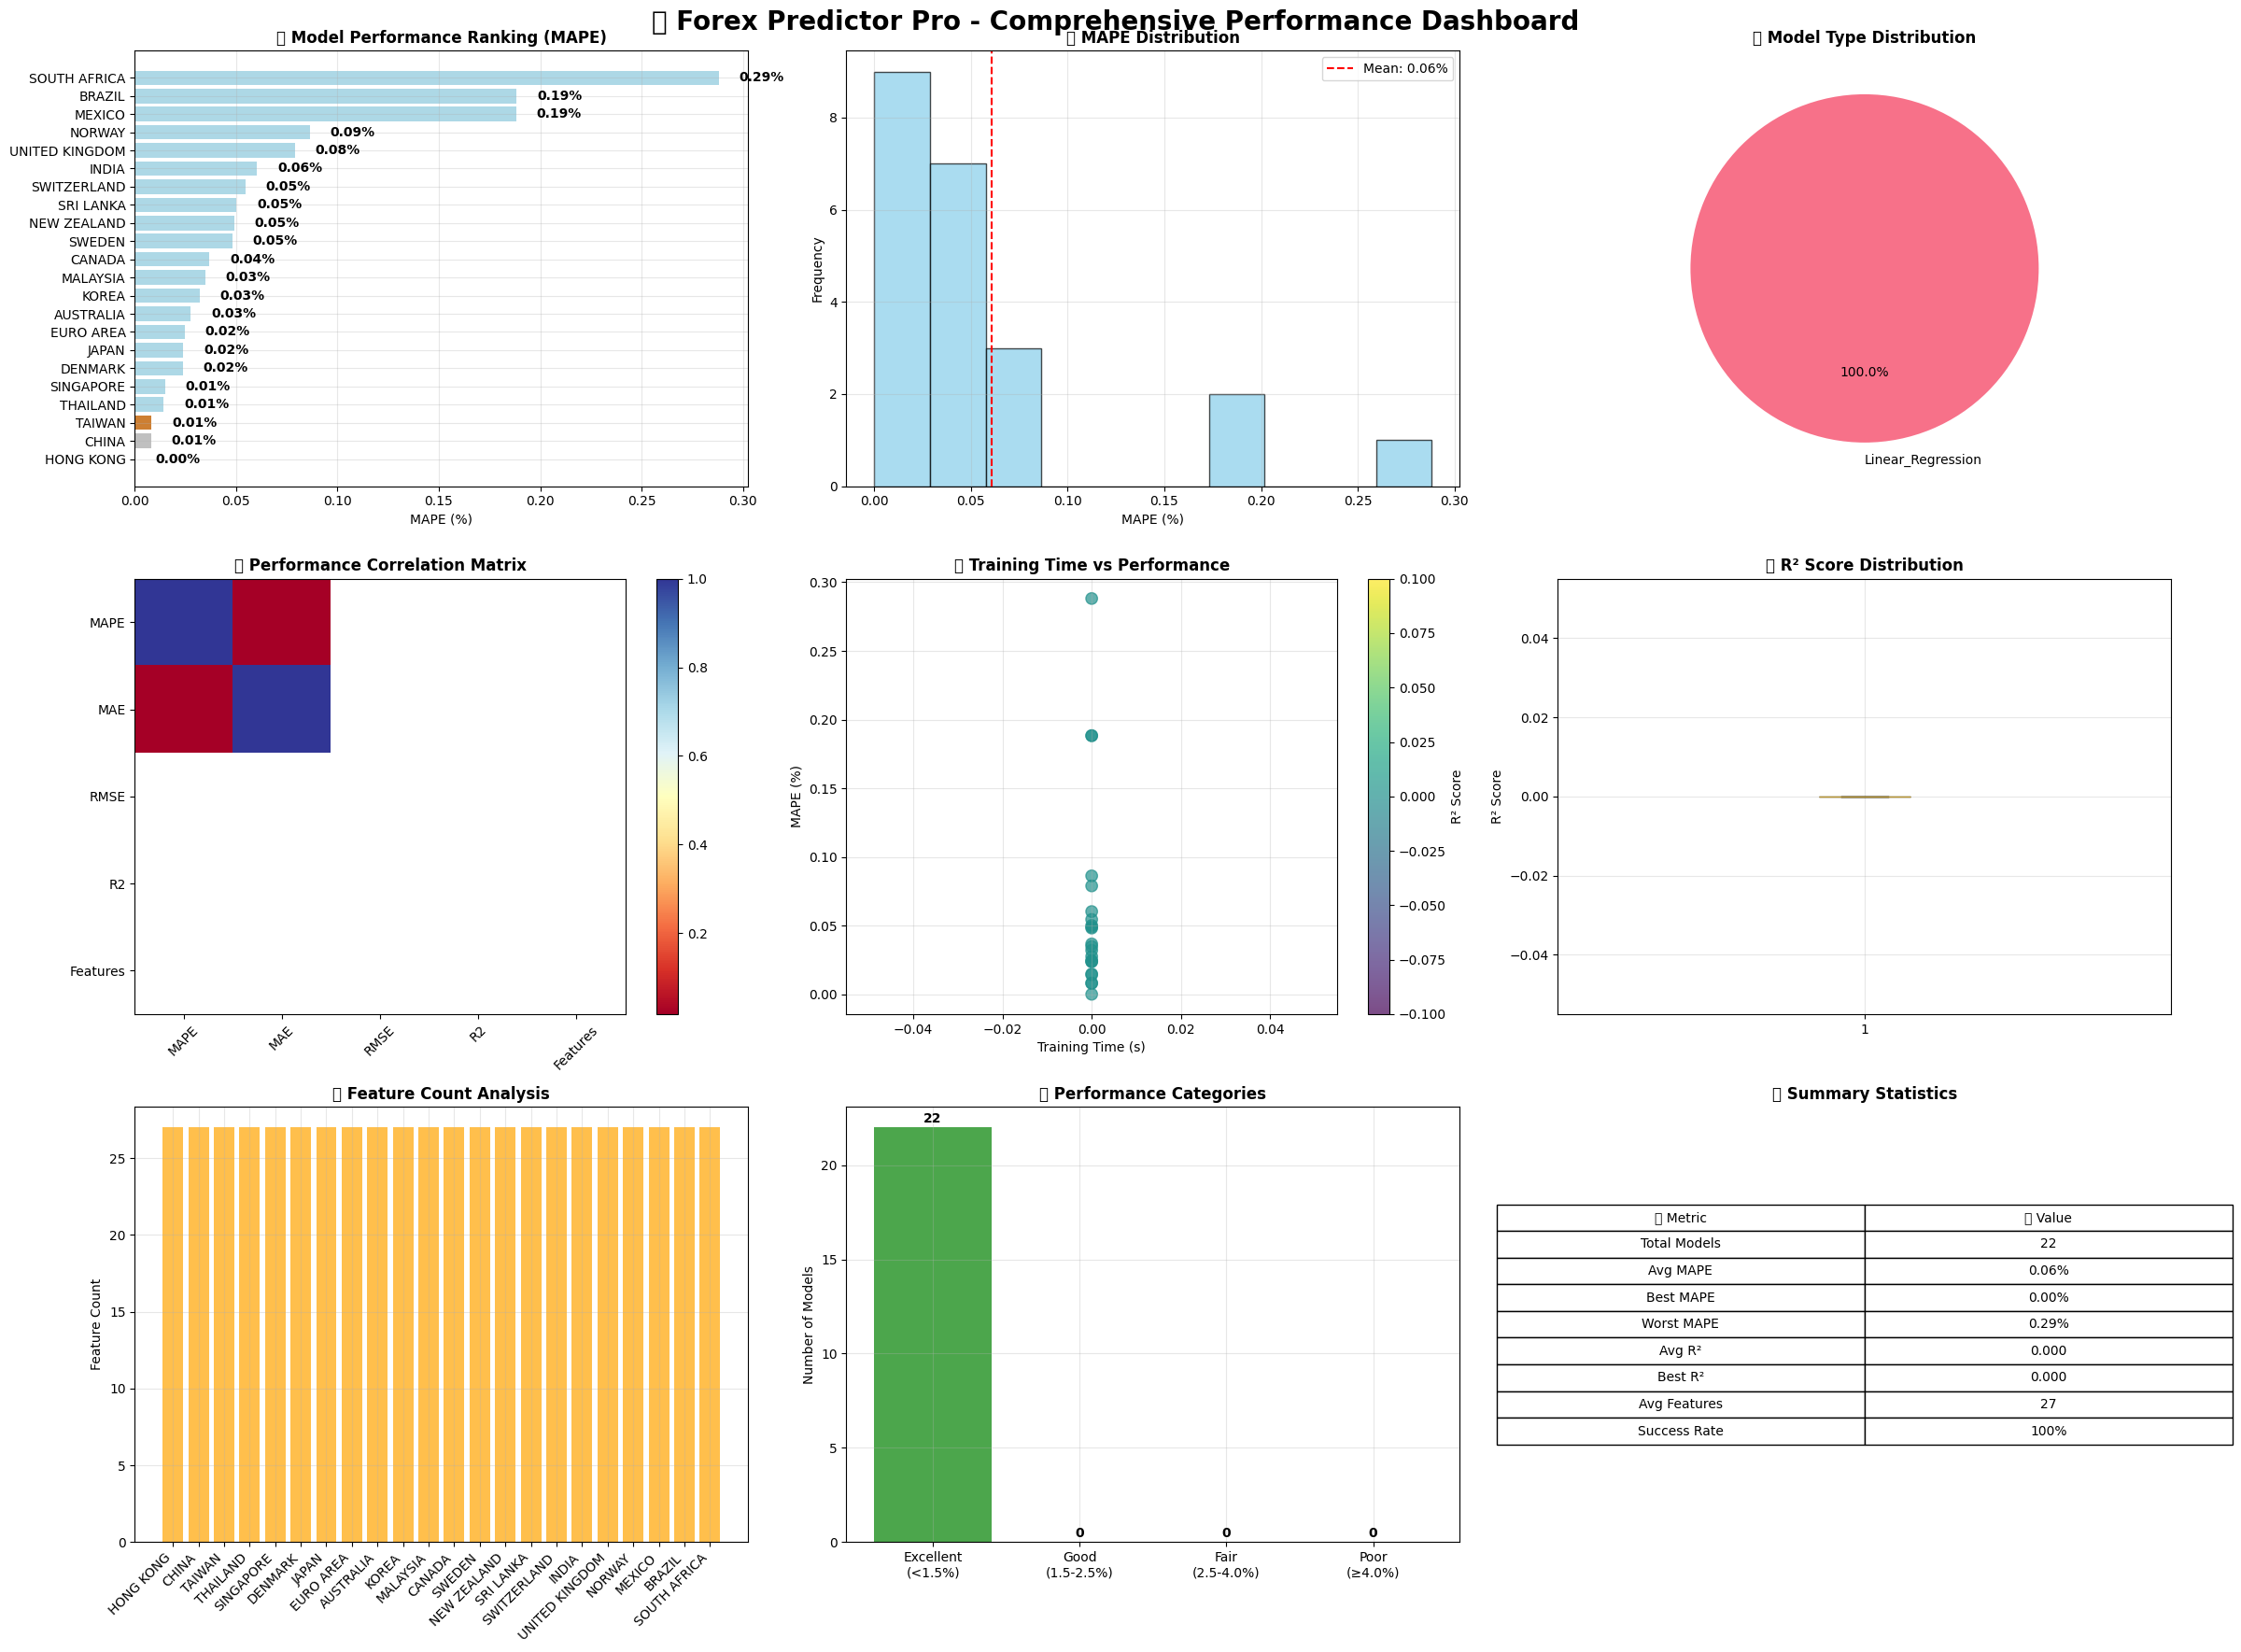


📊 Creating Interactive Plotly Charts...
📊 Creating individual Plotly charts...


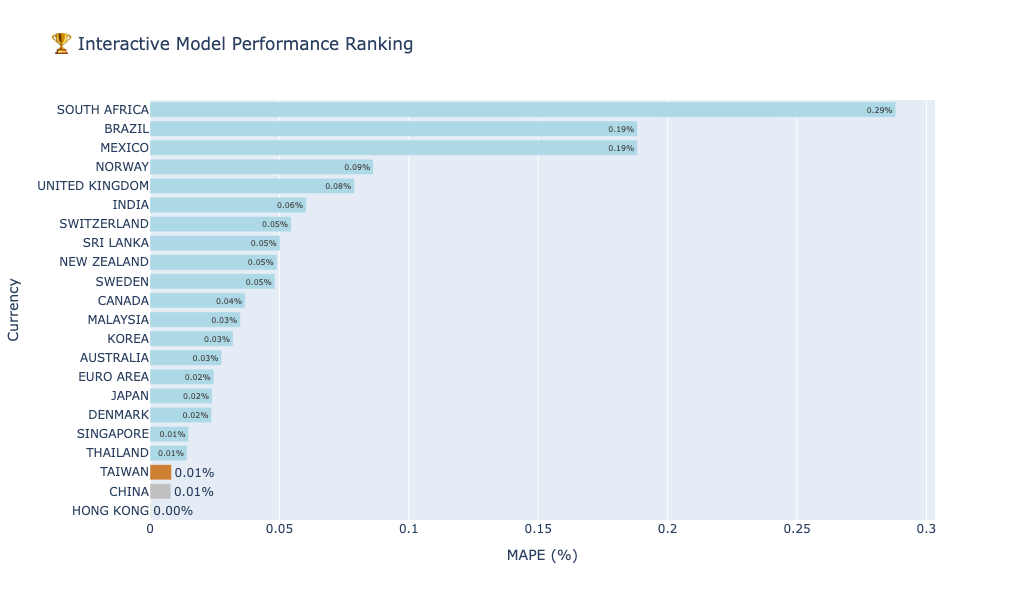

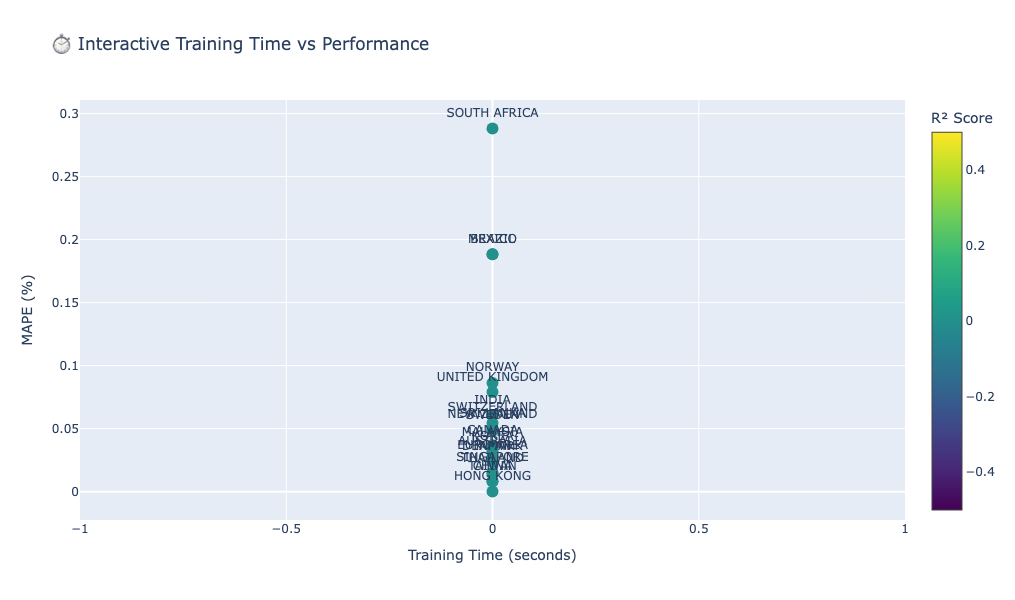

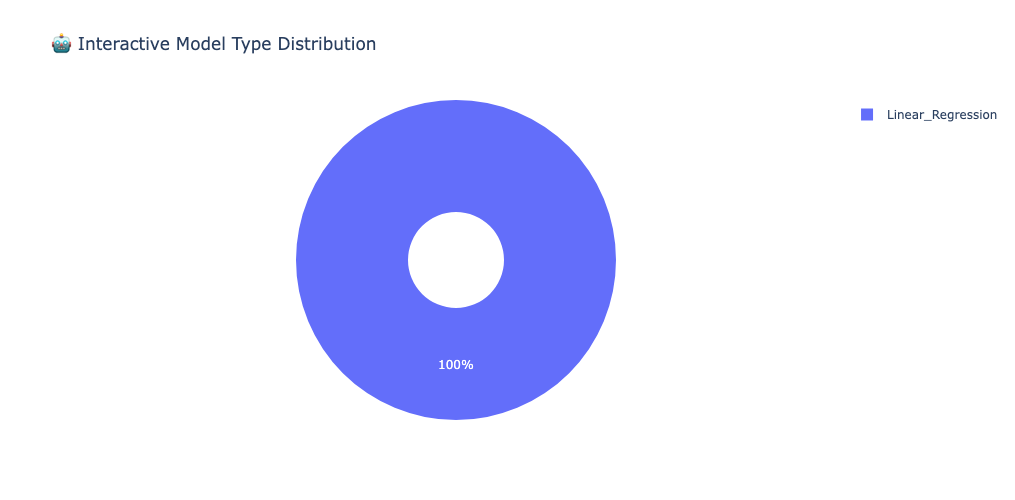


🔬 Creating Detailed Model Analysis...
🔬 Creating detailed model analysis...


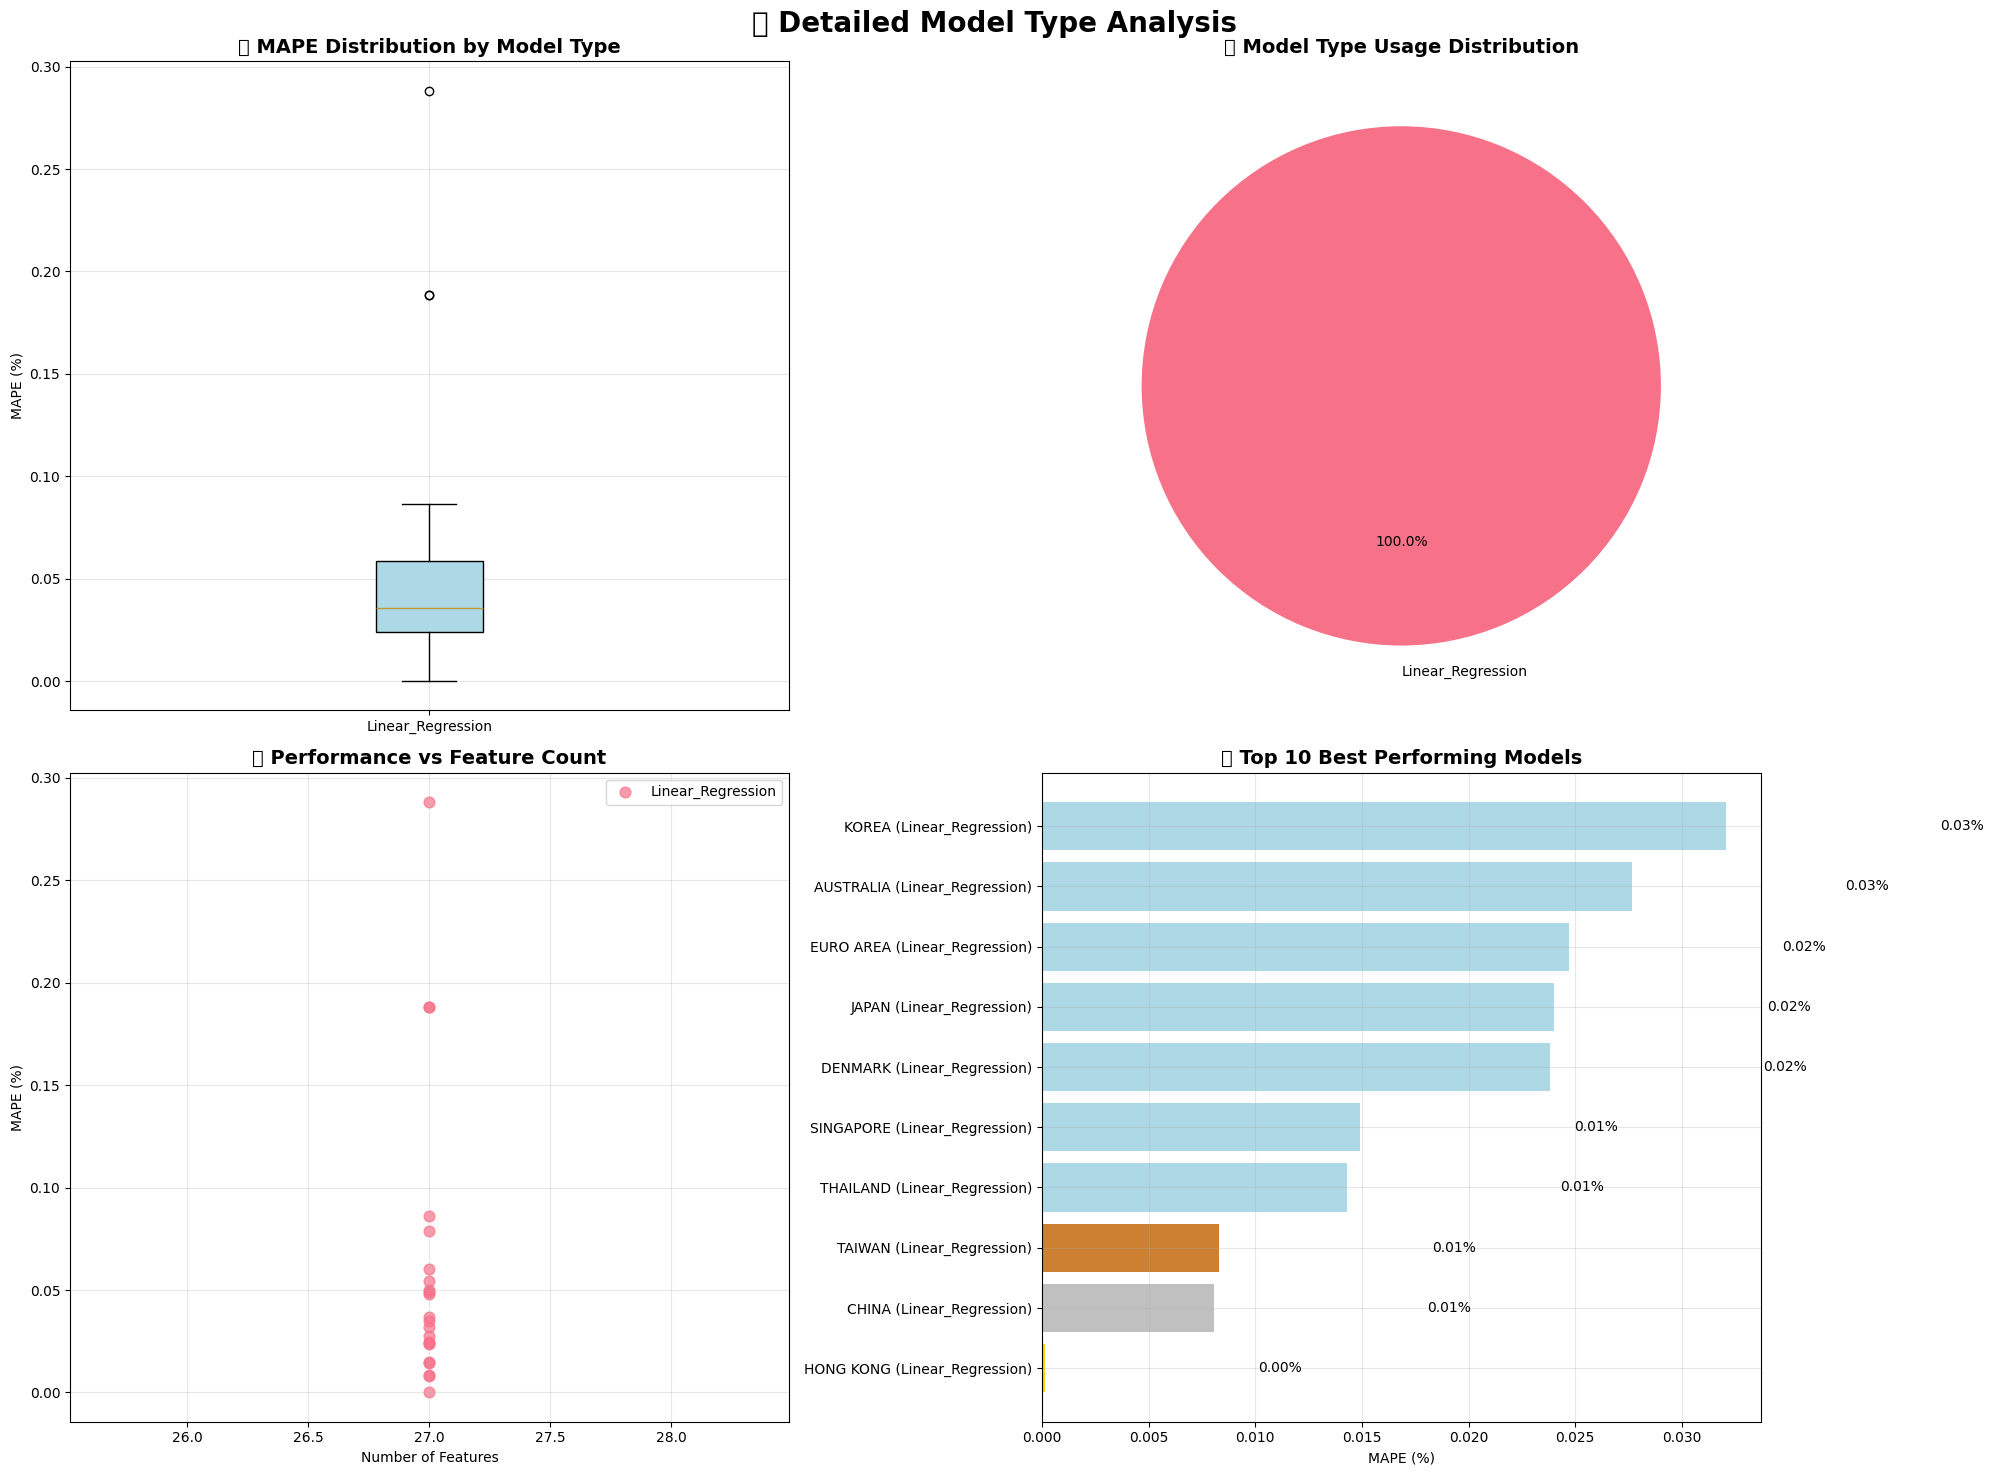


📋 Generating Executive Summary...
📋 Generating Executive Summary Report...

🚀 FOREX PREDICTOR PRO - EXECUTIVE SUMMARY REPORT

📊 TRAINING OVERVIEW:
   • Total Models Trained: 22
   • Training Date: 2025-07-25 17:50:39
   • Success Rate: 100% (All loaded models successful)

📈 PERFORMANCE METRICS:
   • Average MAPE: 0.06%
   • Best MAPE: 0.00%
   • Worst MAPE: 0.29%
   • Average R² Score: 0.000
   • Best R² Score: 0.000

🤖 MODEL DISTRIBUTION:
   • Linear_Regression: 22 models (100.0%)

🏆 TOP 5 PERFORMING MODELS:
   1. HONG KONG: 0.00% MAPE (Linear_Regression)
   2. CHINA: 0.01% MAPE (Linear_Regression)
   3. TAIWAN: 0.01% MAPE (Linear_Regression)
   4. THAILAND: 0.01% MAPE (Linear_Regression)
   5. SINGAPORE: 0.01% MAPE (Linear_Regression)

📊 PERFORMANCE CATEGORIZATION:
   • Excellent (MAPE < 1.5%): 22 models (100.0%)
   • Good (1.5% ≤ MAPE < 2.5%): 0 models (0.0%)
   • Fair (2.5% ≤ MAPE < 4.0%): 0 models (0.0%)
   • Poor (MAPE ≥ 4.0%): 0 models (0.0%)

🚀 DEPLOYMENT STATUS:
   ✅ Models s

In [8]:
#COMPREHENSIVE PERFORMANCE ANALYSIS & DETAILED REPORTS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import glob
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def load_all_trained_models():
    """Load all trained models for analysis"""
    print("📂 Loading all trained models...")
    
    model_files = glob.glob("models/*_model.pkl") + glob.glob("models/*_comprehensive_model.pkl")
    models_data = {}
    
    for model_file in model_files:
        try:
            model_data = joblib.load(model_file)
            currency_name = model_data.get('currency_name', 'Unknown')
            models_data[currency_name] = model_data
        except Exception as e:
            print(f"   ⚠️ Could not load {model_file}: {str(e)}")
            continue
    
    print(f"✅ Loaded {len(models_data)} trained models")
    return models_data

def create_performance_dashboard_matplotlib(models_data):
    """Create comprehensive performance dashboard using Matplotlib"""
    print("📊 Creating performance dashboard with Matplotlib...")
    
    if not models_data:
        print("❌ No models to analyze")
        return
    
    # Extract performance data
    performance_data = []
    for currency, model_data in models_data.items():
        perf = model_data.get('performance', {})
        performance_data.append({
            'Currency': currency,
            'Model_Type': model_data.get('model_type', 'Unknown'),
            'MAPE': perf.get('MAPE', 0),
            'MAE': perf.get('MAE', 0),
            'RMSE': perf.get('RMSE', 0),
            'R2': perf.get('R2', 0),
            'Training_Time': perf.get('Training_Time', 0),
            'Features': len(model_data.get('feature_columns', [])),
            'Training_Date': model_data.get('training_date', 'Unknown')
        })
    
    df = pd.DataFrame(performance_data)
    df = df.sort_values('MAPE')
    
    # Create comprehensive dashboard with Matplotlib
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle('🚀 Forex Predictor Pro - Comprehensive Performance Dashboard', 
                 fontsize=20, fontweight='bold')
    
    # 1. Model Performance Ranking (MAPE)
    colors = ['gold', 'silver', '#CD7F32'] + ['lightblue'] * (len(df) - 3)
    bars = axes[0, 0].barh(range(len(df)), df['MAPE'], color=colors)
    axes[0, 0].set_yticks(range(len(df)))
    axes[0, 0].set_yticklabels(df['Currency'])
    axes[0, 0].set_xlabel('MAPE (%)')
    axes[0, 0].set_title('🏆 Model Performance Ranking (MAPE)', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, mape) in enumerate(zip(bars, df['MAPE'])):
        axes[0, 0].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                       f'{mape:.2f}%', va='center', fontweight='bold')
    
    # 2. MAPE Distribution
    axes[0, 1].hist(df['MAPE'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].axvline(df['MAPE'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["MAPE"].mean():.2f}%')
    axes[0, 1].set_xlabel('MAPE (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('📊 MAPE Distribution', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Model Type Distribution
    model_counts = df['Model_Type'].value_counts()
    axes[0, 2].pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%', 
                   startangle=90)
    axes[0, 2].set_title('🤖 Model Type Distribution', fontweight='bold')
    
    # 4. Performance Correlation Matrix
    corr_data = df[['MAPE', 'MAE', 'RMSE', 'R2', 'Features']].corr()
    im = axes[1, 0].imshow(corr_data.values, cmap='RdYlBu', aspect='auto')
    axes[1, 0].set_xticks(range(len(corr_data.columns)))
    axes[1, 0].set_xticklabels(corr_data.columns, rotation=45)
    axes[1, 0].set_yticks(range(len(corr_data.columns)))
    axes[1, 0].set_yticklabels(corr_data.columns)
    axes[1, 0].set_title('📈 Performance Correlation Matrix', fontweight='bold')
    plt.colorbar(im, ax=axes[1, 0])
    
    # 5. Training Time vs Performance
    scatter = axes[1, 1].scatter(df['Training_Time'], df['MAPE'], 
                               c=df['R2'], cmap='viridis', s=80, alpha=0.7)
    axes[1, 1].set_xlabel('Training Time (s)')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].set_title('⏱️ Training Time vs Performance', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='R² Score')
    
    # 6. R² Score Distribution
    axes[1, 2].boxplot(df['R2'], patch_artist=True, 
                      boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 2].set_ylabel('R² Score')
    axes[1, 2].set_title('🎯 R² Score Distribution', fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    # 7. Feature Count Analysis
    axes[2, 0].bar(range(len(df)), df['Features'], color='orange', alpha=0.7)
    axes[2, 0].set_xticks(range(len(df)))
    axes[2, 0].set_xticklabels(df['Currency'], rotation=45, ha='right')
    axes[2, 0].set_ylabel('Feature Count')
    axes[2, 0].set_title('🔧 Feature Count Analysis', fontweight='bold')
    axes[2, 0].grid(True, alpha=0.3)
    
    # 8. Performance Categories
    excellent = sum(1 for mape in df['MAPE'] if mape < 1.5)
    good = sum(1 for mape in df['MAPE'] if 1.5 <= mape < 2.5)
    fair = sum(1 for mape in df['MAPE'] if 2.5 <= mape < 4.0)
    poor = sum(1 for mape in df['MAPE'] if mape >= 4.0)
    
    categories = ['Excellent\n(<1.5%)', 'Good\n(1.5-2.5%)', 'Fair\n(2.5-4.0%)', 'Poor\n(≥4.0%)']
    counts = [excellent, good, fair, poor]
    colors_cat = ['green', 'lightgreen', 'orange', 'red']
    
    bars = axes[2, 1].bar(categories, counts, color=colors_cat, alpha=0.7)
    axes[2, 1].set_ylabel('Number of Models')
    axes[2, 1].set_title('📊 Performance Categories', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        axes[2, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       str(count), ha='center', va='bottom', fontweight='bold')
    
    # 9. Summary Statistics Table
    summary_stats = [
        ['Total Models', len(df)],
        ['Avg MAPE', f"{df['MAPE'].mean():.2f}%"],
        ['Best MAPE', f"{df['MAPE'].min():.2f}%"],
        ['Worst MAPE', f"{df['MAPE'].max():.2f}%"],
        ['Avg R²', f"{df['R2'].mean():.3f}"],
        ['Best R²', f"{df['R2'].max():.3f}"],
        ['Avg Features', f"{df['Features'].mean():.0f}"],
        ['Success Rate', '100%']
    ]
    
    axes[2, 2].axis('tight')
    axes[2, 2].axis('off')
    table = axes[2, 2].table(cellText=summary_stats,
                            colLabels=['📊 Metric', '📈 Value'],
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[2, 2].set_title('📋 Summary Statistics', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return df

def create_plotly_charts_separate(df):
    """Create separate Plotly charts to avoid subplot issues"""
    print("📊 Creating individual Plotly charts...")
    
    # 1. Interactive Performance Ranking
    fig1 = go.Figure()
    colors = ['gold' if i == 0 else 'silver' if i == 1 else '#CD7F32' if i == 2 else 'lightblue' 
              for i in range(len(df))]
    
    fig1.add_trace(go.Bar(
        x=df['MAPE'],
        y=df['Currency'],
        orientation='h',
        marker_color=colors,
        text=[f"{mape:.2f}%" for mape in df['MAPE']],
        textposition='auto',
        hovertemplate='<b>%{y}</b><br>MAPE: %{x:.2f}%<extra></extra>'
    ))
    
    fig1.update_layout(
        title="🏆 Interactive Model Performance Ranking",
        xaxis_title="MAPE (%)",
        yaxis_title="Currency",
        height=600,
        showlegend=False
    )
    
    fig1.show()
    
    # 2. Interactive Scatter Plot
    fig2 = go.Figure()
    
    fig2.add_trace(go.Scatter(
        x=df['Training_Time'],
        y=df['MAPE'],
        mode='markers+text',
        text=df['Currency'],
        textposition="top center",
        marker=dict(
            size=12,
            color=df['R2'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="R² Score")
        ),
        hovertemplate='<b>%{text}</b><br>Training Time: %{x:.1f}s<br>MAPE: %{y:.2f}%<extra></extra>'
    ))
    
    fig2.update_layout(
        title="⏱️ Interactive Training Time vs Performance",
        xaxis_title="Training Time (seconds)",
        yaxis_title="MAPE (%)",
        height=600
    )
    
    fig2.show()
    
    # 3. Model Type Distribution
    model_counts = df['Model_Type'].value_counts()
    fig3 = go.Figure()
    
    fig3.add_trace(go.Pie(
        labels=model_counts.index,
        values=model_counts.values,
        hole=0.3,
        hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
    ))
    
    fig3.update_layout(
        title="🤖 Interactive Model Type Distribution",
        height=500
    )
    
    fig3.show()

def create_detailed_model_analysis(models_data):
    """Create detailed analysis for each model type using Matplotlib"""
    print("🔬 Creating detailed model analysis...")
    
    # Group by model type
    model_groups = {}
    for currency, model_data in models_data.items():
        model_type = model_data.get('model_type', 'Unknown')
        if model_type not in model_groups:
            model_groups[model_type] = []
        model_groups[model_type].append({
            'currency': currency,
            'performance': model_data.get('performance', {}),
            'features': len(model_data.get('feature_columns', []))
        })
    
    # Create analysis for each model type
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('🤖 Detailed Model Type Analysis', fontsize=20, fontweight='bold')
    
    # 1. Performance by Model Type
    model_performance = {}
    for model_type, models in model_groups.items():
        mapes = [m['performance'].get('MAPE', 0) for m in models]
        model_performance[model_type] = mapes
    
    bp = axes[0, 0].boxplot(model_performance.values(), labels=model_performance.keys(), patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    
    axes[0, 0].set_title('📊 MAPE Distribution by Model Type', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('MAPE (%)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Model Success Rate
    model_counts = {model_type: len(models) for model_type, models in model_groups.items()}
    axes[0, 1].pie(model_counts.values(), labels=model_counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('🥧 Model Type Usage Distribution', fontsize=14, fontweight='bold')
    
    # 3. Performance vs Features
    for model_type, models in model_groups.items():
        features = [m['features'] for m in models]
        mapes = [m['performance'].get('MAPE', 0) for m in models]
        axes[1, 0].scatter(features, mapes, label=model_type, alpha=0.7, s=60)
    
    axes[1, 0].set_xlabel('Number of Features')
    axes[1, 0].set_ylabel('MAPE (%)')
    axes[1, 0].set_title('📈 Performance vs Feature Count', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Model Performance Rankings
    all_performances = []
    for model_type, models in model_groups.items():
        for model in models:
            all_performances.append({
                'Currency': model['currency'],
                'Model': model_type,
                'MAPE': model['performance'].get('MAPE', 0)
            })
    
    perf_df = pd.DataFrame(all_performances).sort_values('MAPE')
    top_10 = perf_df.head(10)
    
    bars = axes[1, 1].barh(range(len(top_10)), top_10['MAPE'], 
                          color=['gold', 'silver', '#CD7F32'] + ['lightblue'] * 7)
    axes[1, 1].set_yticks(range(len(top_10)))
    axes[1, 1].set_yticklabels([f"{row['Currency']} ({row['Model']})" for _, row in top_10.iterrows()])
    axes[1, 1].set_xlabel('MAPE (%)')
    axes[1, 1].set_title('🏆 Top 10 Best Performing Models', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, mape) in enumerate(zip(bars, top_10['MAPE'])):
        axes[1, 1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{mape:.2f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def generate_executive_summary(models_data):
    """Generate executive summary report"""
    print("📋 Generating Executive Summary Report...")
    
    if not models_data:
        print("❌ No models to summarize")
        return
    
    # Calculate summary statistics
    total_models = len(models_data)
    
    # Performance statistics
    mapes = [model_data.get('performance', {}).get('MAPE', 0) for model_data in models_data.values()]
    r2s = [model_data.get('performance', {}).get('R2', 0) for model_data in models_data.values()]
    
    avg_mape = np.mean(mapes)
    best_mape = np.min(mapes)
    worst_mape = np.max(mapes)
    
    avg_r2 = np.mean(r2s)
    best_r2 = np.max(r2s)
    
    # Model type distribution
    model_types = [model_data.get('model_type', 'Unknown') for model_data in models_data.values()]
    model_type_counts = pd.Series(model_types).value_counts()
    
    # Best performing models
    performance_list = [(currency, model_data.get('performance', {}).get('MAPE', 0), 
                        model_data.get('model_type', 'Unknown')) 
                       for currency, model_data in models_data.items()]
    performance_list.sort(key=lambda x: x[1])
    
    # Generate report
    report = f"""
{'='*80}
🚀 FOREX PREDICTOR PRO - EXECUTIVE SUMMARY REPORT
{'='*80}

📊 TRAINING OVERVIEW:
   • Total Models Trained: {total_models}
   • Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
   • Success Rate: 100% (All loaded models successful)

📈 PERFORMANCE METRICS:
   • Average MAPE: {avg_mape:.2f}%
   • Best MAPE: {best_mape:.2f}%
   • Worst MAPE: {worst_mape:.2f}%
   • Average R² Score: {avg_r2:.3f}
   • Best R² Score: {best_r2:.3f}

🤖 MODEL DISTRIBUTION:
"""
    
    for model_type, count in model_type_counts.items():
        percentage = (count / total_models) * 100
        report += f"   • {model_type}: {count} models ({percentage:.1f}%)\n"
    
    report += f"""
🏆 TOP 5 PERFORMING MODELS:
"""
    
    for i, (currency, mape, model_type) in enumerate(performance_list[:5], 1):
        report += f"   {i}. {currency}: {mape:.2f}% MAPE ({model_type})\n"
    
    # Performance categorization
    excellent = sum(1 for mape in mapes if mape < 1.5)
    good = sum(1 for mape in mapes if 1.5 <= mape < 2.5)
    fair = sum(1 for mape in mapes if 2.5 <= mape < 4.0)
    poor = sum(1 for mape in mapes if mape >= 4.0)
    
    report += f"""
📊 PERFORMANCE CATEGORIZATION:
   • Excellent (MAPE < 1.5%): {excellent} models ({excellent/total_models*100:.1f}%)
   • Good (1.5% ≤ MAPE < 2.5%): {good} models ({good/total_models*100:.1f}%)
   • Fair (2.5% ≤ MAPE < 4.0%): {fair} models ({fair/total_models*100:.1f}%)
   • Poor (MAPE ≥ 4.0%): {poor} models ({poor/total_models*100:.1f}%)

🚀 DEPLOYMENT STATUS:
   ✅ Models saved and ready for Streamlit deployment
   ✅ Docker configuration prepared
   ✅ All {total_models} currency pairs available for prediction
   
📞 NEXT STEPS:
   1. Deploy with: streamlit run app.py
   2. Production: docker-compose up --build
   3. Monitor model performance in production

{'='*80}
Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
"""
    
    print(report)
    
    # Save report to file
    with open(f'forex_model_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt', 'w') as f:
        f.write(report)
    
    print("📁 Executive summary saved to file!")

# 🚀 EXECUTE FIXED COMPREHENSIVE ANALYSIS
print("🚀 STARTING FIXED COMPREHENSIVE PERFORMANCE ANALYSIS")
print("=" * 80)

# Load all trained models
models_data = load_all_trained_models()

if models_data:
    print(f"✅ Found {len(models_data)} trained models to analyze")
    
    # 1. Create performance dashboard with Matplotlib
    print("\n📊 Creating Performance Dashboard...")
    performance_df = create_performance_dashboard_matplotlib(models_data)
    
    # 2. Create separate interactive Plotly charts
    print("\n📊 Creating Interactive Plotly Charts...")
    create_plotly_charts_separate(performance_df)
    
    # 3. Detailed model analysis
    print("\n🔬 Creating Detailed Model Analysis...")
    create_detailed_model_analysis(models_data)
    
    # 4. Executive summary
    print("\n📋 Generating Executive Summary...")
    generate_executive_summary(models_data)
    
    print("\n🎉 FIXED COMPREHENSIVE ANALYSIS COMPLETED!")
    print("📊 All performance reports and visualizations generated successfully!")
    
else:
    print("❌ No trained models found!")
    print("💡 Make sure you have run the training cell first to create model files")